# Programming Exercise 8: Anomaly Detection and Recommender Systems

In [58]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# Use to load the OCTAVE *.mat files
from scipy.io import loadmat
# Use for fmincg
from scipy.optimize import minimize


## 1 Anomaly detection

In [2]:
def load(datafile):
    globals().update(loadmat(datafile))


In [3]:
load('machine-learning-ex8/ex8/ex8data1.mat')


In [4]:
def plotData(X):
    plt.plot(X[:, 0], X[:, 1], 'b+')
    plt.xlabel('Latency [ms]', fontsize=16)
    plt.ylabel('Throughput [mb/s]', fontsize=16)


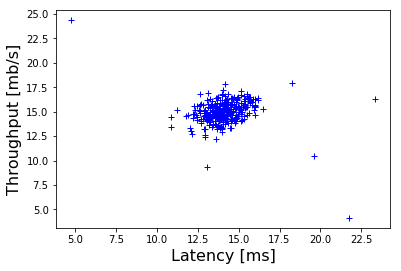

In [5]:
plotData(X)


### 1.1 Gaussian distribution

$$p(x;\mu,\sigma^{2}) = \frac{1}{\sqrt{2\pi\sigma^{2}}}e^{-\frac{(x - \mu)^{2}}{2\sigma^{2}}}$$

In [6]:
def multivariateGaussian(X, mu, cov):
    if np.ndim(cov) == 1:
        cov = np.diag(cov)
    norm = (np.linalg.det(2 * np.pi * cov)) ** (-1 / 2)
    inv = np.linalg.inv(cov)
    centered_X = X - mu
    exp = np.exp(-0.5 * np.sum(centered_X.dot(inv) * centered_X, axis=1)).reshape((-1, 1))
    return norm * exp


### 1.2 Estimating parameters for a Gaussian

$$
\begin{equation}
\begin{split}
\mu_{i} & = \frac{1}{m}\sum_{j=1}^{m}x_{i}^{(j)}\\
\sigma_{i}^{2} & = \frac{1}{m}\sum_{j=1}^{m}(x_{i}^{(j)} - \mu_{i})^{2}
\end{split}
\end{equation}
$$

In [7]:
def estimateGaussian(X, multivariate=True):
    mu = X.mean(axis=0)
    if multivariate:
        return mu, np.cov(X.T)
    else:
        return mu, X.var(axis=0)


In [8]:
def visualizeFit(X):
    plotData(X)
    xx = np.linspace(0, 30)
    X1, X2 = np.meshgrid(xx, xx)
    XX = np.column_stack((X1.ravel(), X2.ravel()))
    Z = multivariateGaussian(XX, *estimateGaussian(X)).reshape(X1.shape)
    plt.contour(X1, X2, Z, levels=np.logspace(-20, 0, 10))


In [9]:
visualizeFit(X)


### 1.3    Selecting the threshold, ε

$$
\begin{equation}
\begin{split}
F_{1} & = \frac{2 * prec * prec}{prec + rec}\\
prec & = \frac{tp}{tp + fp}\\
rec & = \frac{tp}{tp + fn}
\end{split}
\end{equation}
$$

* tp is the number of true positives: the ground truth label says it's an anomaly and our algorithm correctly classified it as an anomaly.
* fp is the number of false positives: the ground truth label says it's not an anomaly, but our algorithm incorrectly classified it as an anomaly.
* fn is the number of false negatives: the ground truth label says it's an anomaly, but our algorithm incorrectly classified it as not being anomalous

In [10]:
def F1_score(y_pred, y):
    assert y_pred.shape == y.shape
    tp = np.sum((y_pred == 1) & (y == 1))
    fp = np.sum((y_pred == 1) & (y == 0))
    fn = np.sum((y_pred == 0) & (y == 1))
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    return 2 * prec * rec / (prec + rec)


In [11]:
def selectThreshold(yval, pval):
    bestF1, bestEpsilon = 0, 0
    for epsilon in np.linspace(np.min(pval), np.max(pval), 1000):
        y_pred = pval < epsilon
        tmp = F1_score(y_pred, yval)
        if tmp <= bestF1:
            break
        bestF1 = tmp
        bestEpsilon = epsilon
    return bestEpsilon, bestF1


In [12]:
# select using the parameters fited to original data, X, not Xval!!!
pval = multivariateGaussian(Xval, *estimateGaussian(X))
epsilon, f1 = selectThreshold(yval, pval)
np.testing.assert_approx_equal(epsilon, 9 * 10 ** -5, significant=2)
np.testing.assert_approx_equal(f1, 0.875)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


In [13]:
visualizeFit(X)
anom = X[np.where(pval < epsilon)[0]]
plt.scatter(anom[:, 0], anom[:, 1], s=80, facecolors='none', edgecolors='r')


### 1.4 High dimensional dataset

In [14]:
load('machine-learning-ex8/ex8/ex8data2.mat')

In [15]:
mu, var = estimateGaussian(X, multivariate=False)
p = multivariateGaussian(X, mu, var)
pval = multivariateGaussian(Xval, mu, var)
epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation:', epsilon)
print('Best F1 on Cross Validation Set:  ', F1)
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)')
print('# Outliers found:', np.sum(p < epsilon))


Best epsilon found using cross-validation: 1.3786074982e-18
Best F1 on Cross Validation Set:   0.615384615385
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found: 117


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


## 2 Recommender Systems

### 2.1 Movie ratings dataset

In [16]:
load('machine-learning-ex8/ex8/ex8_movies.mat')


Average rating for movie 1 (Toy Story): 3.8783185840707963


Text(0.5,0,'Users (943)')

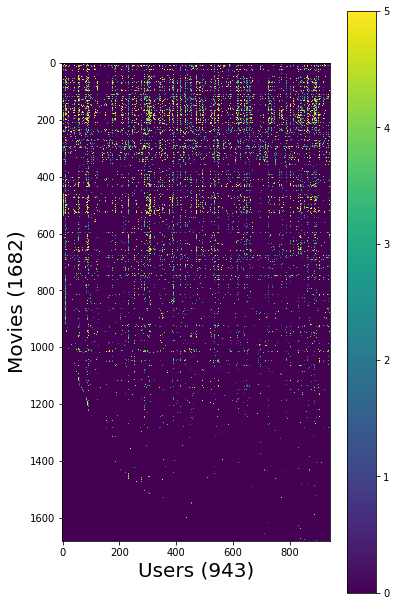

In [17]:
nm, nu = Y.shape
print(f'Average rating for movie 1 (Toy Story): {np.mean(Y[0][np.where(R[0] == 1)[0]])}')
fig = plt.figure(figsize=(6, 6 * (1682. / 943.)))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies (%d)' % nm, fontsize=20)
plt.xlabel('Users (%d)' % nu, fontsize=20)


### 2.2 Collaborative filtering learning algorithm

In [18]:
def unroll_params(params):
    return np.concatenate([param.ravel() for param in params])


In [19]:
def reshape_params(params, num_users, num_movies, num_features):
    # Unfold the U and W matrices from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    return X, Theta


#### 2.2.1 Collaborative filtering cost function

#### 2.2.3 Regularized cost function

$$J(x^{(1)}, \dots, x^{(n_{u})}, \theta^{(1)}, \dots, \theta^{(n_{u})}) = \frac{1}{2}\sum_{(i, j):r(i, j) = 1}((\theta^{(j)})^{T}x^{(i)} - y^{(i, j)})^{2} + \bigg(\frac{\lambda}{2}\sum_{j=1}^{n_{u}}\sum_{k=1}^{n}(\theta_{k}^{(j)})^{2}\bigg) + \bigg(\frac{\lambda}{2}\sum_{i=1}^{n_{m}}\sum_{k=1}^{n}(x_{k}^{(i)})^{2}\bigg)$$

#### 2.2.2 Collaborative filtering gradient

#### 2.2.4 Regularized gradient

$$
\begin{equation}
\begin{split}
\frac{\partial J}{\partial x_{k}^{(i)}} & = \sum_{j:r(i,j)=1}((\theta^{(j)})^{T}x^{(i)}-y^{(i,j)})\theta_{k}^{(j)} + \lambda x_{k}^{(i)}\\
\frac{\partial J}{\partial \theta_{k}^{(j)}} & = \sum_{i:r(i,j)=1}((\theta^{(j)})^{T}x^{(i)}-y^{(i,j)})x_{k}^{(i)} + \lambda \theta_{k}^{(j)}
\end{split}
\end{equation}
$$

In [41]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):
    X, Theta = reshape_params(params, num_users, num_movies, num_features)
    estimation_error = (X.dot(Theta.T) - Y) * R
    cost = np.sum(estimation_error ** 2) / 2
    X_reg = lambda_ * np.sum(X ** 2) / 2
    Theta_reg = lambda_ * np.sum(Theta ** 2) / 2
    X_grad = estimation_error.dot(Theta) + lambda_ * X
    Theta_grad = estimation_error.T.dot(X) + lambda_ * Theta
    grad = unroll_params((X_grad, Theta_grad))
    assert grad.shape == params.shape
    return cost + X_reg + Theta_reg, grad


In [48]:
def checkGradients(cost_func, params, _lambda):
    # Short hand for cost function
    costFunc = lambda p: cost_func(p, _lambda)
    cost, grad = costFunc(params)

    def computeNumericalGradient(J, theta):
        # numerical estimate of the gradient
        numgrad = np.zeros(theta.shape)
        perturb = np.zeros(theta.shape)
        e = 10 ** -4
        for p in range(theta.size):
            # Set perturbation vector
            perturb[p] = e
            loss1 = J(theta - perturb)[0]
            loss2 = J(theta + perturb)[0]
            # Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2 * e)
            perturb[p] = 0
        return numgrad

    numgrad = computeNumericalGradient(costFunc, params)
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    assert diff < 10 ** -9
    return diff


In [196]:
load('machine-learning-ex8/ex8/ex8_movieParams.mat')
num_users = 4
num_movies = 5
num_features = 3;
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]
params = unroll_params((X, Theta))
cost_func = lambda p, lambd: cofiCostFunc(p, Y, R, num_users, num_movies, num_features, lambd)
# Evaluate cost function
J = cost_func(params, 0)
np.testing.assert_approx_equal(J[0], 22.22, significant=4)
print(f'Cost at loaded parameters:{J[0]} (this value should be about 22.22)')
print(checkGradients(cost_func, params, 0))
J = cost_func(params, 1.5)
np.testing.assert_approx_equal(J[0], 31.34, significant=4)
print('Cost at loaded parameters (lambda = 1.5): {J[0]} (this value should be about 31.34)')
print(checkGradients(cost_func, params, 1.5))


Cost at loaded parameters:22.224603725685675 (this value should be about 22.22)
8.94700050872e-13
Cost at loaded parameters (lambda = 1.5): {J[0]} (this value should be about 31.34)
2.19310818329e-12


### 2.3 Learning movie recommendations

In [239]:
load('machine-learning-ex8/ex8/ex8_movies.mat')
movies = open('machine-learning-ex8/ex8/movie_ids.txt', "rb").read().split(b"\n")


#### 2.3.1 Recommendations

In [240]:
my_ratings = np.zeros((Y.shape[0], 1))
my_R = np.zeros((R.shape[0], 1))
my_ratings_dict = {
    0  : 4,
    6  : 3,
    11 : 5,
    53 : 4,
    63 : 5,
    65 : 3,
    68 : 5,
    97 : 2,
    182: 4,
    225: 5,
    354: 5
}
print("Original ratings provided:")
for index, rating in my_ratings_dict.items():
    my_ratings[index] = rating
    my_R[index] = 1
    print(f"Rated {rating} for {' '.join(movies[index].decode('ascii').split(' ')[1:])}")


Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


In [241]:
Y = np.column_stack((Y, my_ratings))
R = np.column_stack((R, my_R))


In [242]:
def normalizeRatings(Y, R):
    Y_mean = (np.sum(Y * R, axis=1) / np.sum(R, axis=1)).reshape((-1, 1))
    return Y - Y_mean, Y_mean


In [243]:
Ynorm, Ymean = normalizeRatings(Y, R)
assert (Ynorm.shape[0] == Ymean.shape[0])
assert (Y.shape == Ynorm.shape)

num_movies, num_users = Y.shape
num_features = 10
# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = unroll_params((X, Theta))


In [244]:
cost_func = lambda p: cofiCostFunc(p, Y, R, num_users, num_movies, num_features, lambda_=10)
result = minimize(cost_func, initial_parameters, method="L-BFGS-B", jac=True, options={
    "maxiter": 50
})
result


      fun: 72477.370954722268
 hess_inv: <26260x26260 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.90047988,  12.61802168, -36.24193959, ...,  -0.07780554,
        -0.04337073,   0.59048571])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 58
      nit: 51
   status: 1
  success: False
        x: array([-0.19167426,  0.27759991,  1.29781931, ...,  0.68038109,
       -0.05982536, -0.52787633])

In [245]:
# Unfold the returned theta back into U and W
X, Theta = reshape_params(result.x, num_users, num_movies, num_features)


In [248]:
# After training the model, you can now make recommendations 
# by computing the predictions matrix.
p = X.dot(Theta.T)
# my_predictions = p[:, -1] + Ymean.ravel()
my_predictions = p[:, -1]
assert p.shape == Y.shape


In [249]:
for i in my_predictions.ravel().argsort()[-10:][::-1]:
    print(f"Predicting rating {my_predictions[i]} for movie {movies[i].decode('ascii')}")


Predicting rating 4.314308639137451 for movie 313 Titanic (1997)
Predicting rating 4.116974965066295 for movie 50 Star Wars (1977)
Predicting rating 4.007571599160337 for movie 174 Raiders of the Lost Ark (1981)
Predicting rating 3.9993037318315383 for movie 272 Good Will Hunting (1997)
Predicting rating 3.960786584398742 for movie 181 Return of the Jedi (1983)
Predicting rating 3.94493153836209 for movie 64 Shawshank Redemption, The (1994)
Predicting rating 3.8912857315535394 for movie 22 Braveheart (1995)
Predicting rating 3.873165363095644 for movie 172 Empire Strikes Back, The (1980)
Predicting rating 3.8503449949229873 for movie 258 Contact (1997)
Predicting rating 3.8078718950680543 for movie 318 Schindler's List (1993)
